# SWMAL Exercise

## Pipelines

In [23]:
%matplotlib inline

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def LoadDataFromL01():
    filename = "itmal_l01_data.pkl"
    with open(f"{filename}", "rb") as f:
        (X, y) = pickle.load(f)
        return X, y

X, y = LoadDataFromL01()

print(f"X.shape={X.shape},  y.shape={y.shape}")

assert X.shape[0] == y.shape[0]
assert X.ndim == 2
assert y.ndim == 1  # did a y.ravel() before saving to picke file
assert X.shape[0] == 29

# re-create plot data (not stored in the Pickel file)
m = np.linspace(0, 60000, 1000)
M = np.empty([m.shape[0], 1])
M[:, 0] = m

print("OK")

X.shape=(29, 1),  y.shape=(29,)
OK


###  Revisiting the problem with the MLP

The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..

lin.reg.score(X, y)=0.73
    MLP.score(X, y)=-613358.72

OK


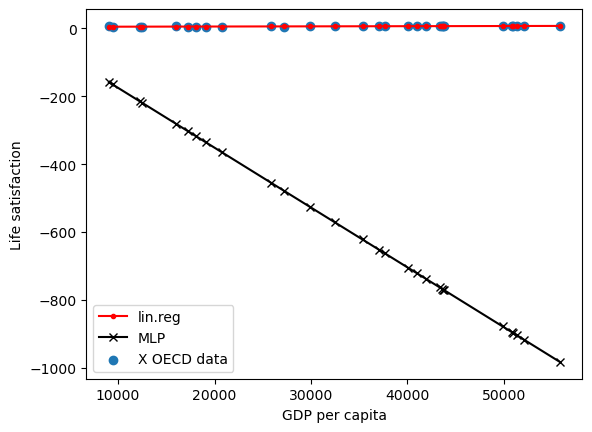

In [24]:
# Setup the MLP and lin. regression again..

def isNumpyData(t: np.ndarray, expected_ndim: int):
    assert isinstance(expected_ndim, int), f"input parameter 'expected_ndim' is not an integer but a '{type(expected_ndim)}'"
    assert expected_ndim>=0, f"expected input parameter 'expected_ndim' to be >=0, got {expected_ndim}"
    if t is None:
        print("input parameter 't' is None", file=sys.stderr)
        return False
    if not isinstance(t, np.ndarray):
        print("excepted numpy.ndarray got type '{type(t)}'", file=sys.stderr)
        return False
    if not t.ndim==expected_ndim:
        print("expected ndim={expected_ndim} but found {t.ndim}", file=sys.stderr)
        return False
    return True

def PlotModels(model1, model2, X: np.ndarray, y: np.ndarray, name_model1: str, name_model2: str):
    
    # NOTE: local function is such a nifty feature of Python!
    def CalcPredAndScore(model, X: np.ndarray, y: np.ndarray,):
        assert isNumpyData(X, 2) and isNumpyData(y, 1) and X.shape[0]==y.shape[0]
        y_pred_model = model.predict(X)
        score_model = r2_score(y, y_pred_model) # call r2
        return y_pred_model, score_model    

    assert isinstance(name_model1, str) and isinstance(name_model2, str)

    y_pred_model1, score_model1 = CalcPredAndScore(model1, X, y)
    y_pred_model2, score_model2 = CalcPredAndScore(model2, X, y)

    plt.plot(X, y_pred_model1, "r.-")
    plt.plot(X, y_pred_model2, "kx-")
    plt.scatter(X, y)
    plt.xlabel("GDP per capita")
    plt.ylabel("Life satisfaction")
    plt.legend([name_model1, name_model2, "X OECD data"])

    l = max(len(name_model1), len(name_model2))
    
    print(f"{(name_model1).rjust(l)}.score(X, y)={score_model1:0.2f}")
    print(f"{(name_model2).rjust(l)}.score(X, y)={score_model2:0.2f}")

# lets make a linear and MLP regressor and redo the plots
mlp = MLPRegressor(hidden_layer_sizes=(10, ),
                   solver='adam',
                   activation='relu',
                   tol=1E-5,
                   max_iter=100000,
                   verbose=False)
linreg = LinearRegression()

mlp.fit(X, y)
linreg.fit(X, y)

print("The MLP may mis-fit the data, seen in the, sometimes, bad R^2 score..\n")
PlotModels(linreg, mlp, X, y, "lin.reg", "MLP")
print("\nOK")

### Qa) Create a Min/max scaler for the MLP

In this assignment we made a function that shows how we can calculate the scaler for an MLP. 
We can calculate the scaler by using the equation 

![](figs/pipeline.png)
After using the new scaler we can retrain our MLP

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.72

OK


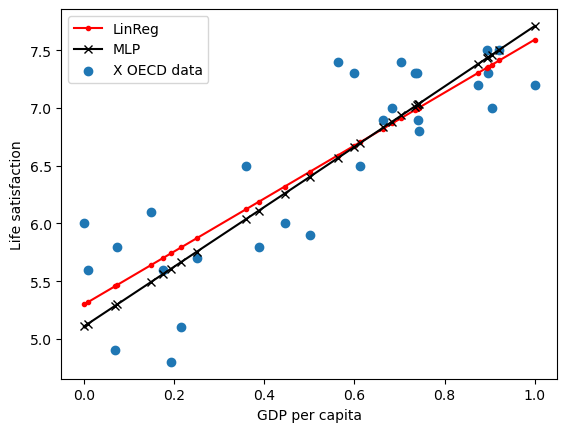

In [25]:

def manualminmaxscaler(data, feature_range): 
    min_val = feature_range[0]
    max_val = feature_range[1]
    data_min = data.min(axis=0)
    data_max = data.max(axis=0)
    scaled_data = min_val + (max_val - min_val) * (data - data_min) / (data_max - data_min)
    return scaled_data

scaled_X = manualminmaxscaler(X, feature_range=(0,1))

mlp.fit(scaled_X,y)
linreg.fit(scaled_X,y)
PlotModels(linreg,mlp, scaled_X,y,"LinReg","MLP")
print(f"\nOK")

### Qb) Scikit-learn Pipelines
In this assignment we are going to be using a pipeline to help simplify running our scaler and fitting our MLP model once again. It does this by running MinMaxScaler() and mlp.fit() whenever we run pipeline.fit

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.72


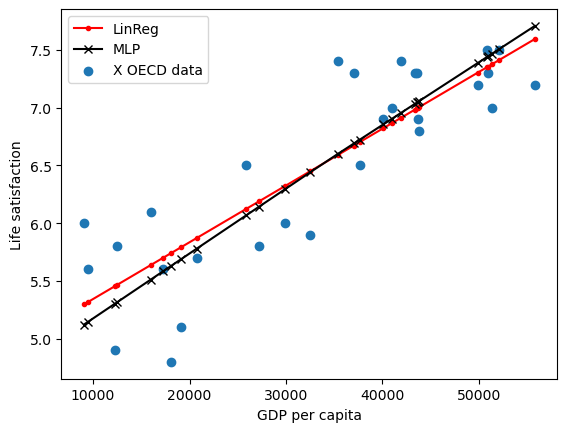

In [26]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
pipeline.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, pipeline, X, y, "LinReg", "MLP")

### Qc) Outliers and the Min-max Scaler vs. the Standard Scaler
Outliers can be a huge problem when using MinMaxScaler() when doing machine learning, as the scaler can easily be influenced when fitting and change the outcome of training even if there is only a single outlier in the dataset. This can be somewhat negated when using a StandardScaler, this is because the StandScaler does some normalization on the dataset to make sure outliers have a smaller influence on the overall training.  

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.80


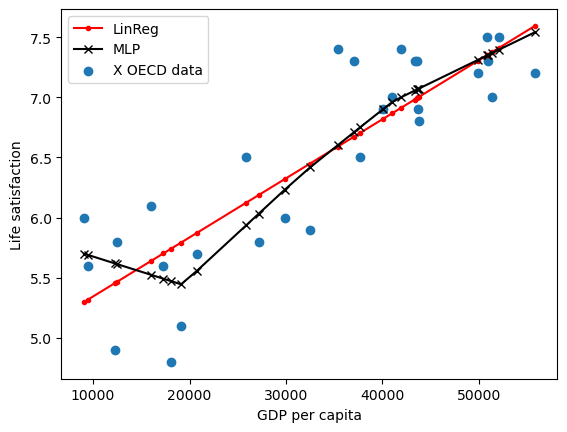

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelineStandard = Pipeline(
    [
        ('Scaler',StandardScaler()),
        ('mlp',mlp)
    ]
)

pipelineStandard.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, pipelineStandard, X, y, "LinReg", "MLP")

### Qd) Modify the MLP Hyperparameters
In this assignment we change the hyperparameters for the MLP to see what difference it's going to make. We are going to be changing the amount of neurons, the solver and the activation to see what effect it has on the mlp.  

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


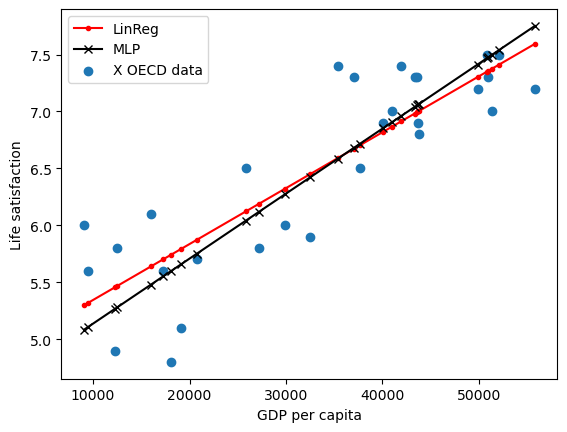

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(2, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final2neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final2neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final2neuronpipe, X, y, "LinReg", "MLP")


LinReg.score(X, y)=0.73
   MLP.score(X, y)=-0.01


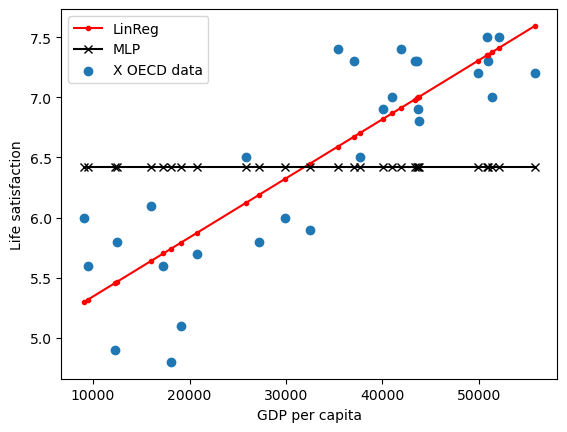

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(1, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final1neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final1neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final1neuronpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.71


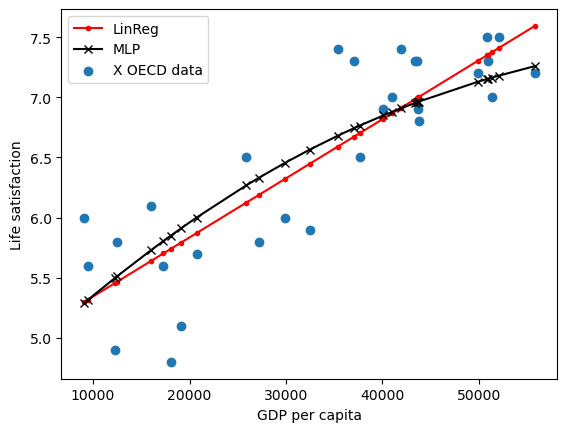

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(5, ),
    solver='adam',
    activation='logistic',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final5neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final5neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final5neuronpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=0.73


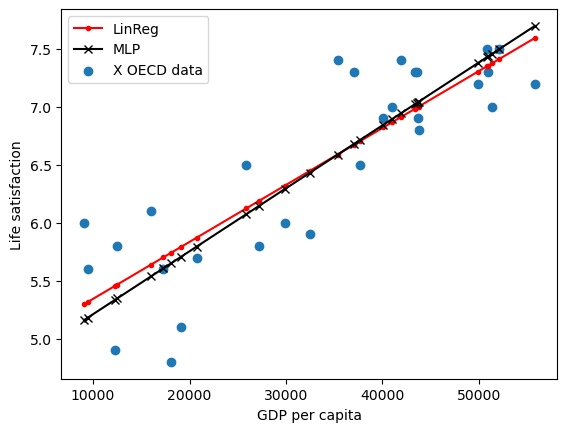

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(10, ),
    solver='adam',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final10neuronpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final10neuronpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final10neuronpipe, X, y, "LinReg", "MLP")

LinReg.score(X, y)=0.73
   MLP.score(X, y)=-0.40


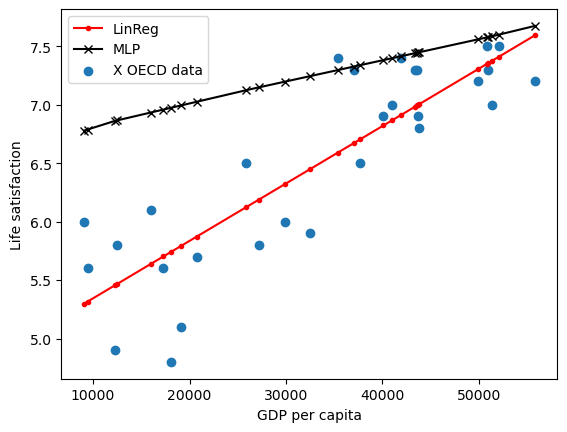

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

mlp = MLPRegressor(
    hidden_layer_sizes=(10, ),
    solver='sgd',
    activation='relu',
    tol=1E-5,
    max_iter=100000,
    verbose=False)

final10neuronnewsolverpipe = Pipeline(
    [
        ('Scaler',MinMaxScaler()),
        ('mlp',mlp)
    ]
)
final10neuronnewsolverpipe.fit(X,y)
linreg.fit(X,y)
PlotModels(linreg, final10neuronnewsolverpipe, X, y, "LinReg", "MLP")